# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [1]:
%load_ext autoreload
%autoreload 2

### 0.2 测试数据生成

In [2]:
import numpy as np
fs = 1000.0
t = np.arange(0, 5, 1/fs)

# 多个谐波分量
harmonics = (
    2 * np.sin(2 * np.pi * 50 * t) +      # 50Hz
    1.5 * np.sin(2 * np.pi * 120 * t) +   # 120Hz
    np.sin(2 * np.pi * 250 * t)           # 250Hz
)

# 冲击序列
impulse = np.zeros_like(t)
impulse_indices = [200, 500, 700]
impulse[impulse_indices] = [5, -4, 6]

# 随机噪声冲击
random_impulse = np.zeros_like(t)
random_indices = np.random.choice(len(t), 5, replace=False)
random_impulse[random_indices] = np.random.uniform(-3, 3, size=5)

# 白噪声
white_noise = np.random.normal(0, 0.5, size=len(t))

# 合成信号
Data = harmonics + impulse + random_impulse + white_noise


## 1. Signal模块测试

### 1.1 Signal.Signal()

Signal(data=[ 0.08378837  2.03152177  2.82583021 ... -1.70145159 -2.01873664
 -2.82630646], fs=1000.0, label=测试信号)


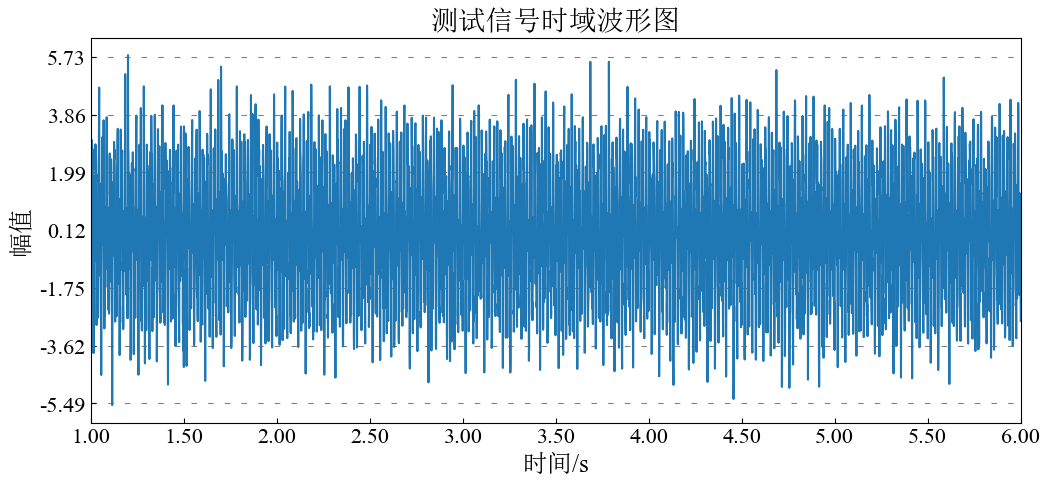

In [8]:
from PySP.Signal import Signal

try:
    Sig = Signal(Data,fs=fs, label="测试信号",t0=1.0)
    print(repr(Sig))
    Sig.plot()
except Exception as e:
    print(e)

### 1.2 Signal.Resample()

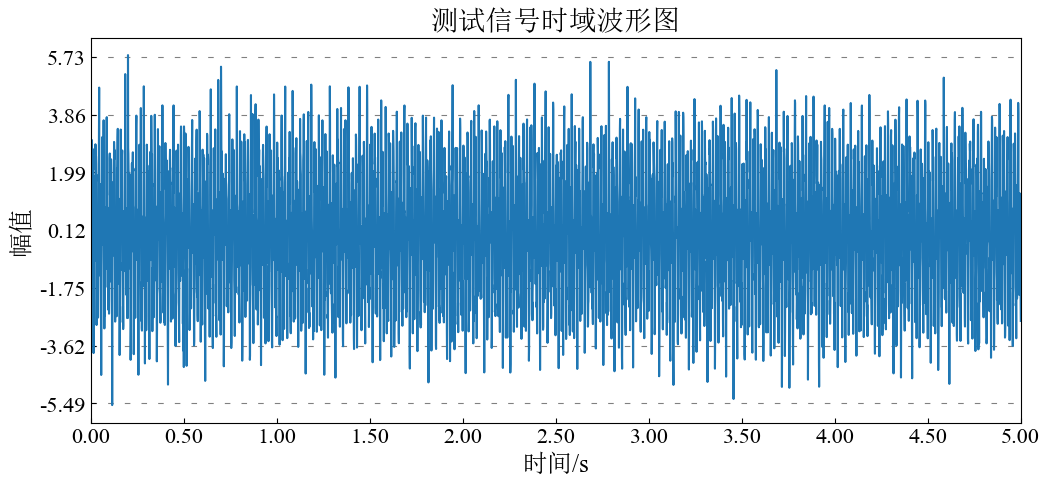

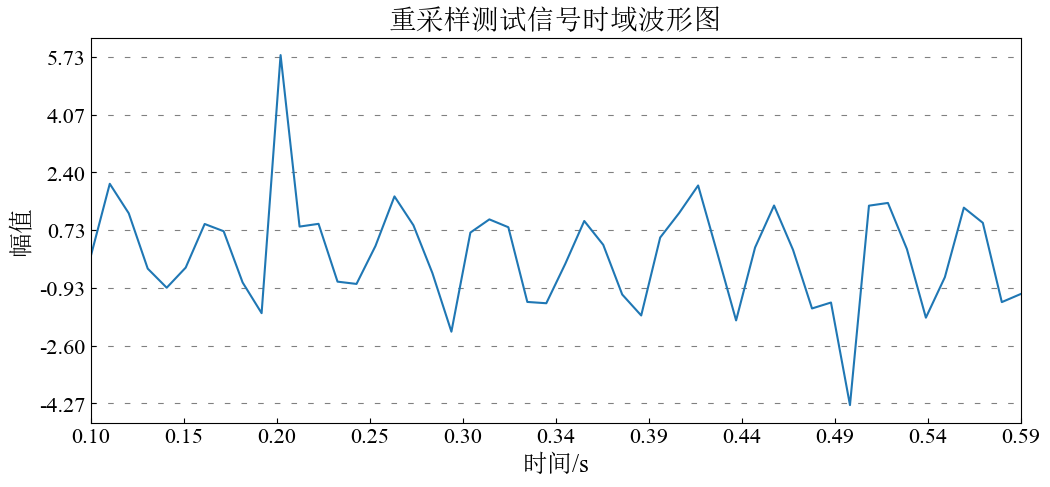

测试信号的采样参数: 
N: 5000
fs: 1000.0 Hz
t0: 0 s
dt: 0.001 s
T: 5.00 s
t1: 5.00 s
df: 0.2 Hz
fn: 500.00 Hz


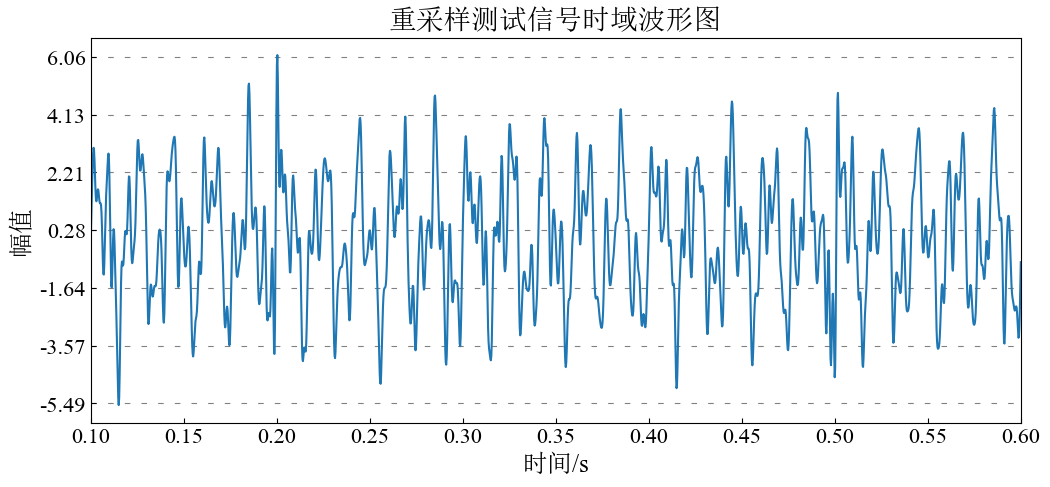

测试信号的采样参数: 
N: 5000
fs: 1000.0 Hz
t0: 0 s
dt: 0.001 s
T: 5.00 s
t1: 5.00 s
df: 0.2 Hz
fn: 500.00 Hz


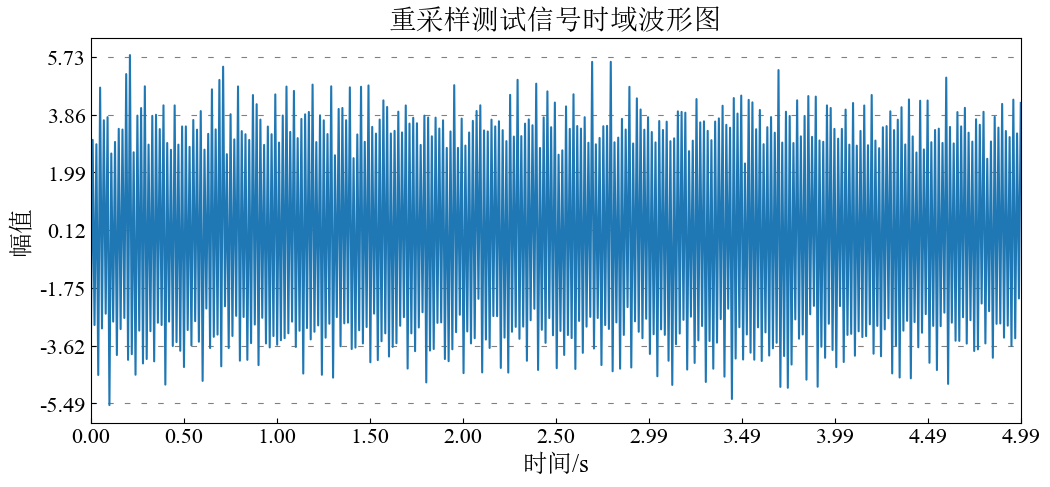

测试信号的采样参数: 
N: 5000
fs: 1000.0 Hz
t0: 0 s
dt: 0.001 s
T: 5.00 s
t1: 5.00 s
df: 0.2 Hz
fn: 500.00 Hz


In [16]:
from PySP.Signal import Signal,Resample

try:
    Sig = Signal(data=Data,fs=fs,label='测试信号')
    Sig.plot()
    _Sig=Resample(Sig=Sig,fs_resampled=100.0,t0=0.1,T=0.5)
    _Sig.plot()
    print(Sig)
    _Sig=Resample(Sig=Sig,type='fft',fs_resampled=4000.0,t0=0.1,T=0.5)
    _Sig.plot()
    print(Sig)
    _Sig=Resample(Sig=Sig,type='extreme',fs_resampled=100.0)
    _Sig.plot()
    print(Sig)
except Exception as e:
    print(e)

### 1.3 Signal.Periodic()

Signal(data=[ 2.83975743  1.60316303 -0.47644471 ...  0.97478008  2.12363902
  1.1165534 ], fs=1000.0, label=仿真含噪准周期信号)


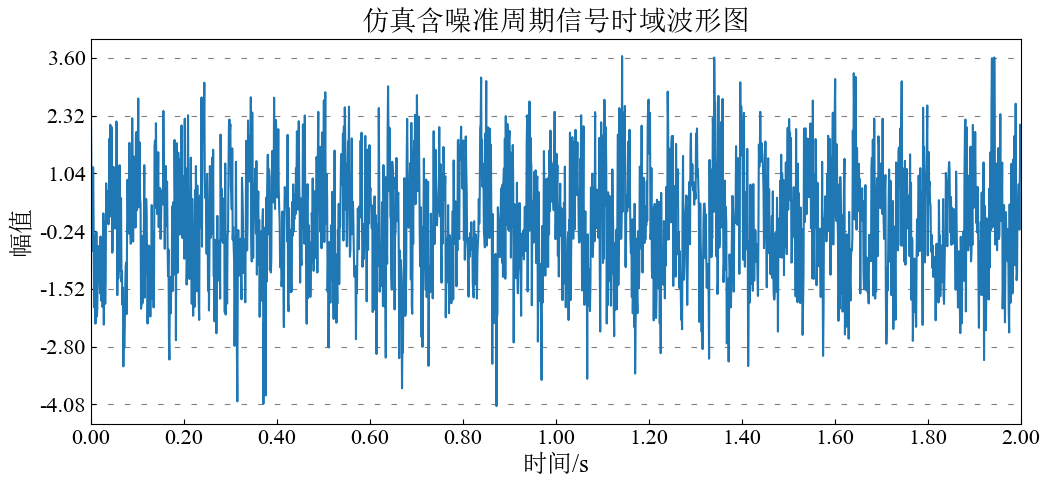

In [19]:
from PySP.Signal import Periodic

try:
    Sig = Periodic(fs=1000.0,T=2.0,CosParams=((20,1,32),(50,0.5,0)),noise=1.0)
    print(repr(Sig))
    Sig.plot()
except Exception as e:
    print(e)

## 2. Analysis模块测试

### 2.1 Analysis.Analysis()

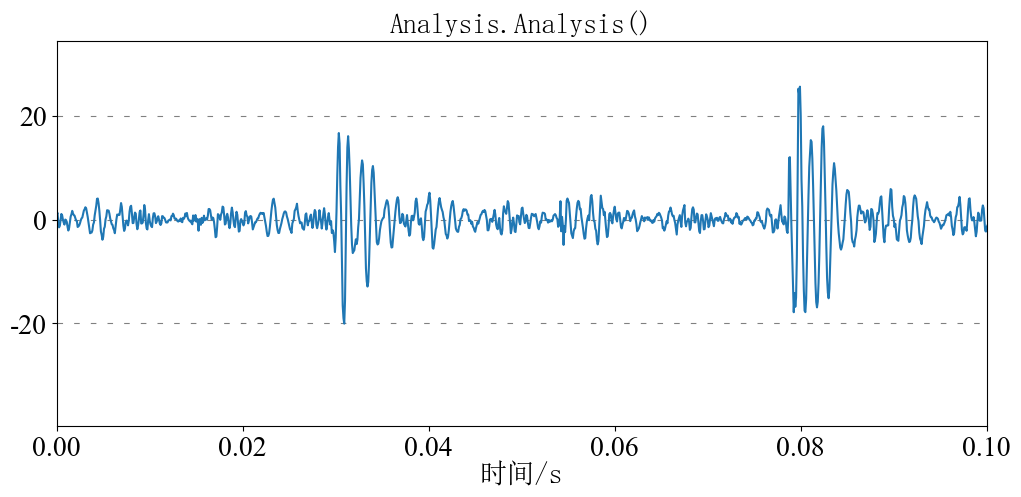

In [13]:
from PySP.Analysis import Analysis
from PySP.Signal import Signal
from PySP.Plot import LinePlotFunc
from PySP.decorators import InputCheck

try:

    class TestAnalysis(Analysis):

        @Analysis.Plot(LinePlotFunc)
        @InputCheck({"x": {"OpenLow": 0}})
        def run(self, x: float):
            t_Axis = self.Sig.t_Axis
            data = self.Sig.data * x
            return t_Axis, data

    Sig = Signal(data=Data, fs=fs)
    test = TestAnalysis(
        Sig,
        isPlot=True,
        xlabel="时间/s",
        xlim=(0, 0.1),
        title="Analysis.Analysis()",
        height=2,
    )
    test.run(2.0)

except Exception as e:
    print(e)

## 2. Plot模块测试

### 2.1 Plot.Plot()

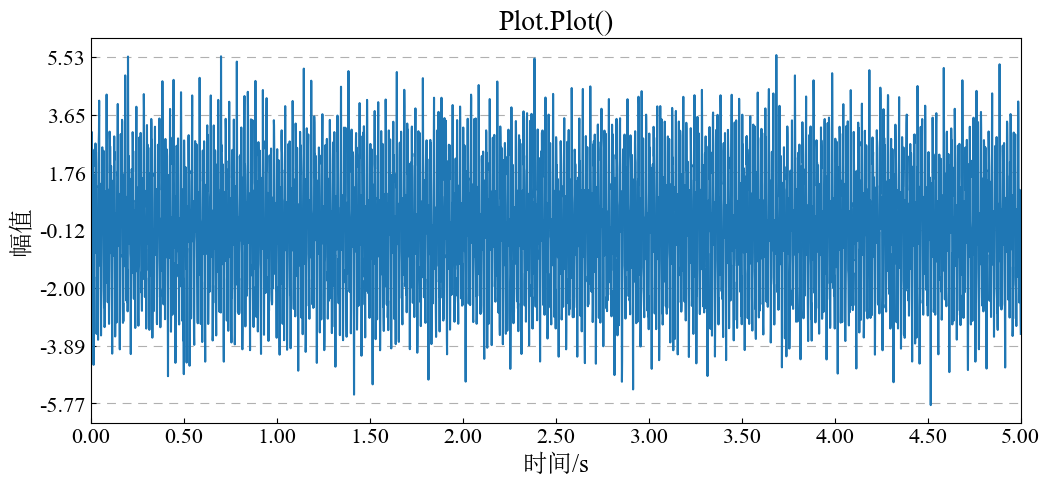

In [ ]:
from PySP.Plot import Plot
from PySP.Signal import Signal

try:
    Sig = Signal(data=Data, fs=fs, label="测试信号")

    class TestPlot(Plot):

        def testplot(self, Sig):
            # 创建图形和坐标轴
            self._setup_figure()
            # 设置标题
            self._setup_title()
            self.axes.plot(Sig.t_Axis, Sig.data, label=Sig.label)
            # 设置x轴
            self._setup_x_axis()
            # 设置y轴
            self._setup_y_axis()
            return self.show()
    test=TestPlot(
        xlabel="时间/s",
        ylabel="幅值",
        title="Plot.Plot()",
    ).testplot(Sig)
except Exception as e:
    print(e)

### 2.2 Plot.LinePlot()

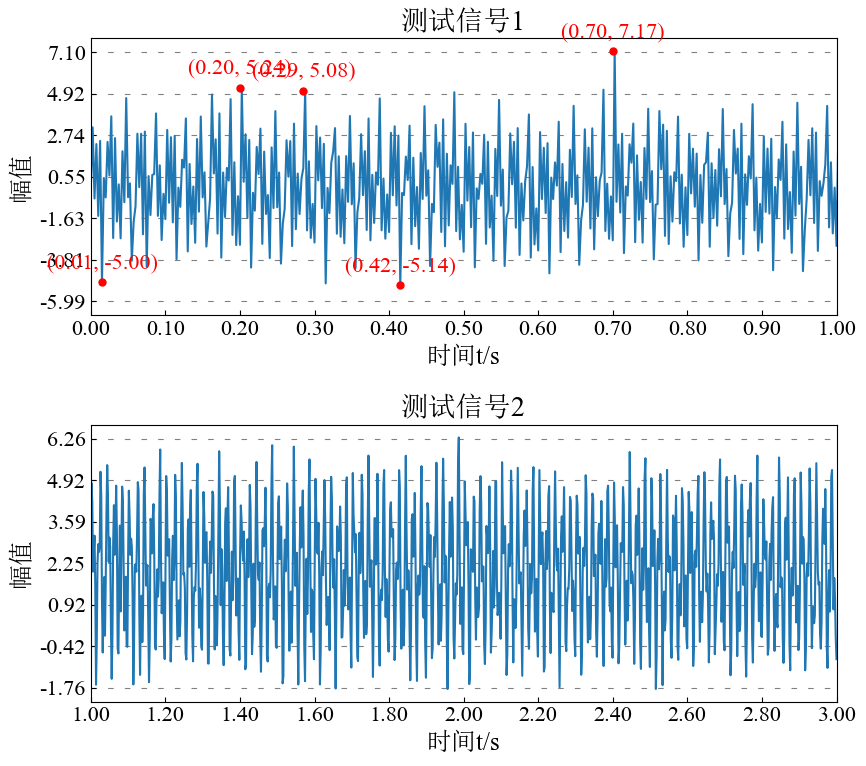

In [9]:
from PySP.Plot import LinePlot,PeakfinderPlugin
from PySP.Signal import Signal,Resample

try:
    Sig1 = Signal(data=Data, fs=fs, label="测试信号")
    Sig2 = Sig1 + 2
    Sig2=Resample(Sig=Sig2,type='fft',fs_resampled=500.0,t0=1.0,T=2.0)
    Sig1.label="测试信号1"
    Sig2.label="测试信号2"
    Plot=LinePlot(isSampled=True,xlabel="时间t/s", ylabel="幅值", title="Plot.LinePlot()")
    Plot.TimeWaveform(
       Sig1,title="测试信号1"
    )
    Plot.set_params_to_task(xlim=(0,1))
    Plot.add_plugin_to_task(PeakfinderPlugin(height=5,distance=50))
    Plot.TimeWaveform(
       Sig2,title="测试信号2"
    )
    Plot.show()
except Exception as e:
    print(e)

### 2.3 Plot.imshow()

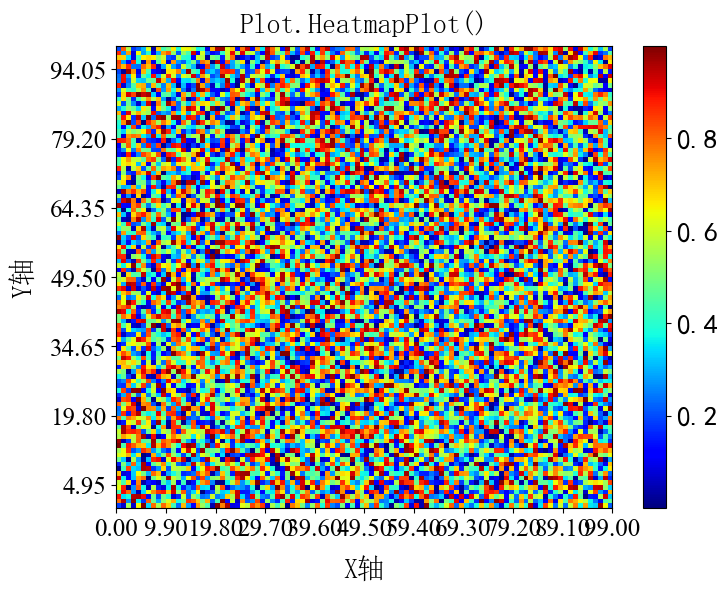

In [60]:
from PySP.Plot import HeatmapPlot
from numpy import random

try:
    Axis1 = np.arange(100)
    Axis2 = np.arange(100)
    data = random.random((100, 100))

    HeatmapPlot(
        figsize=(8, 6), xlabel="X轴", ylabel="Y轴", title="Plot.HeatmapPlot()"
    ).show(Axis1=Axis1, Axis2=Axis2, Data=data)
except Exception as e:
    print(e)

### 2.4 Plot.PeakfinderPlugin()

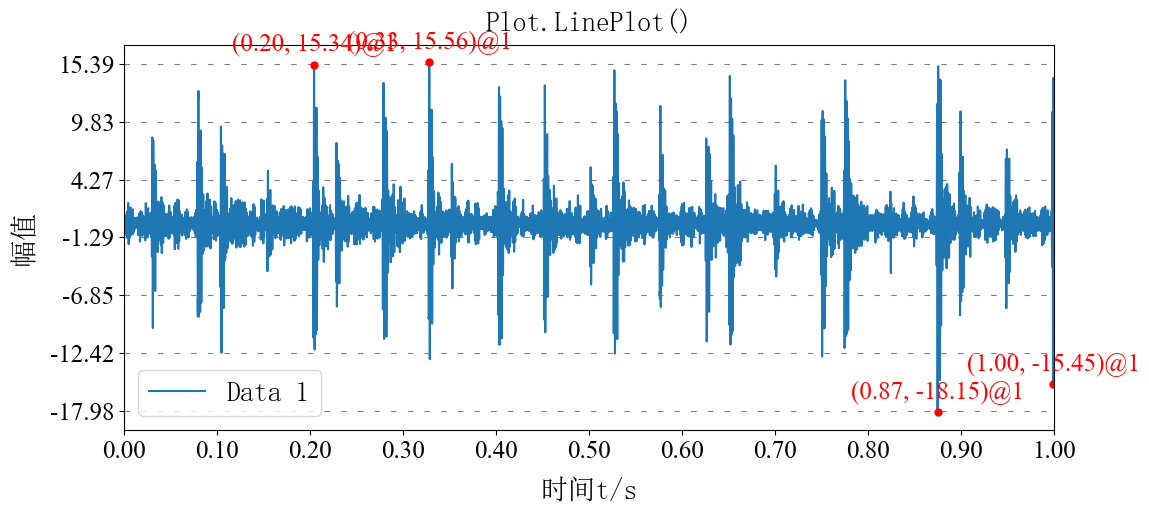

In [ ]:
from PySP.Plot import PeakfinderPlugin,LinePlot
from PySP.Signal import Signal

try:
    Sig = Signal(data=Data, fs=fs, label="测试信号")

    fig=LinePlot(xlabel="时间t/s", ylabel="幅值", title="Plot.LinePlot()")
    fig.add_plugin(
        PeakfinderPlugin(
            height=15,
            distance=100,
        )
    )
    fig.show(Axis=Sig.t_Axis, Data=Sig.data)
except Exception as e:
    print(e)

## 3.BasicSP模块测试

### 3.1 BasicSP.window()

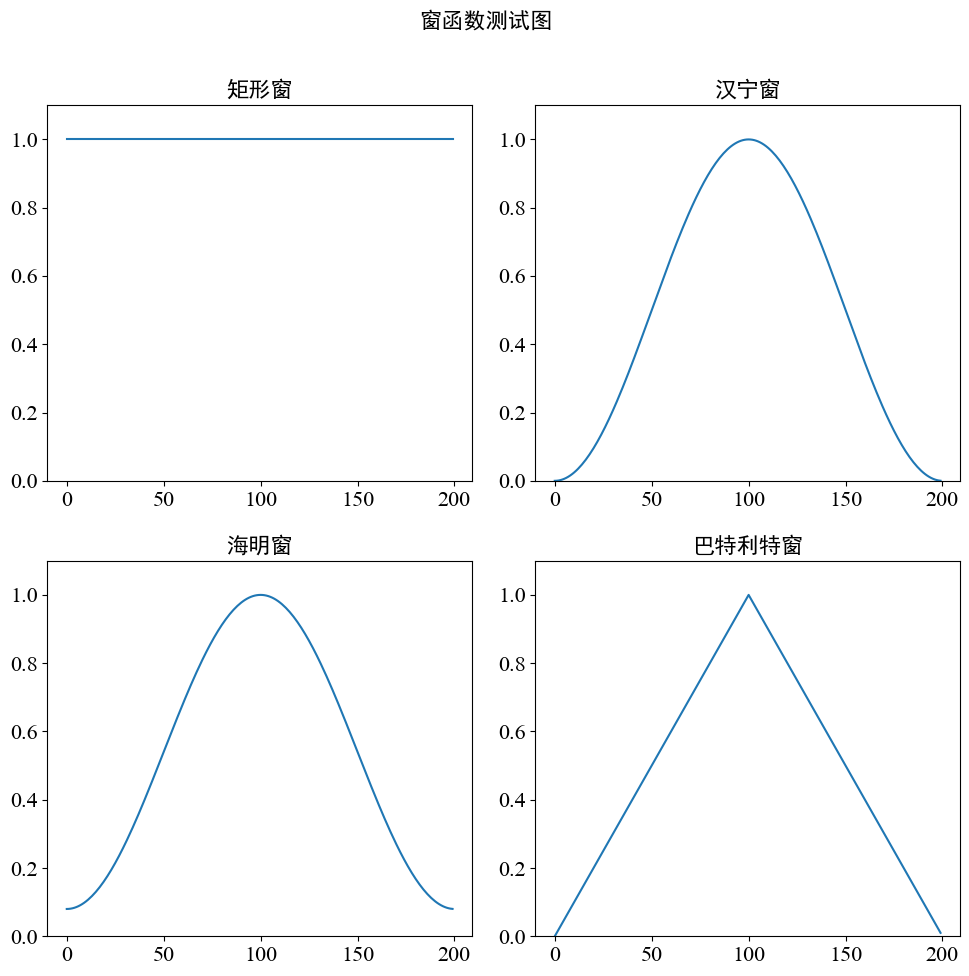

res1:  <class 'numpy.float64'>
res2:  <class 'numpy.float64'>
res3:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import window

try:
    Sig=window(type="汉宁窗",num=200,padding=50,check=True)
    for i,r in enumerate(Sig):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.2 BasicSP.Time_Analysis()

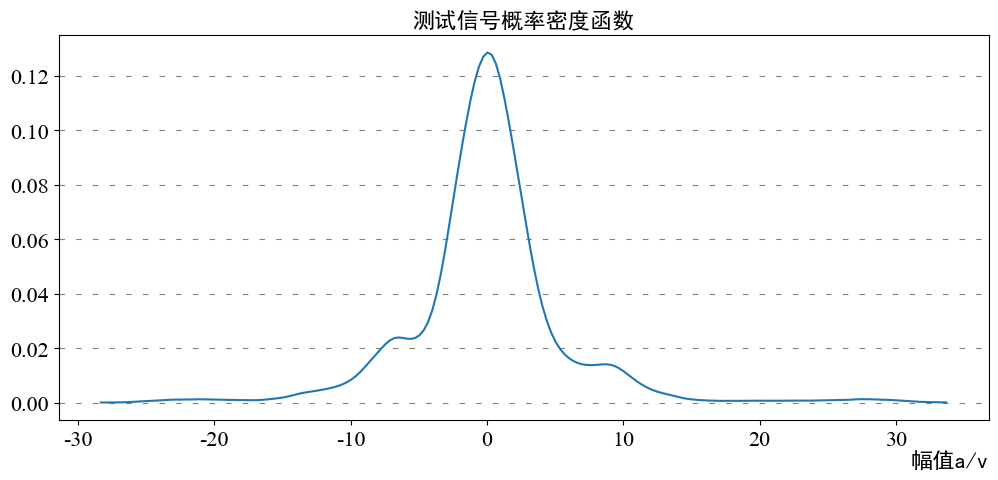

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


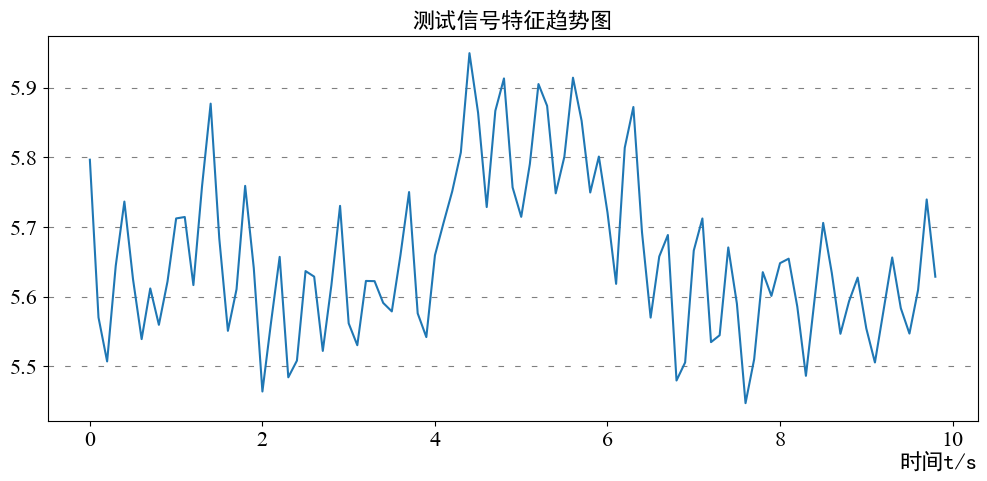

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


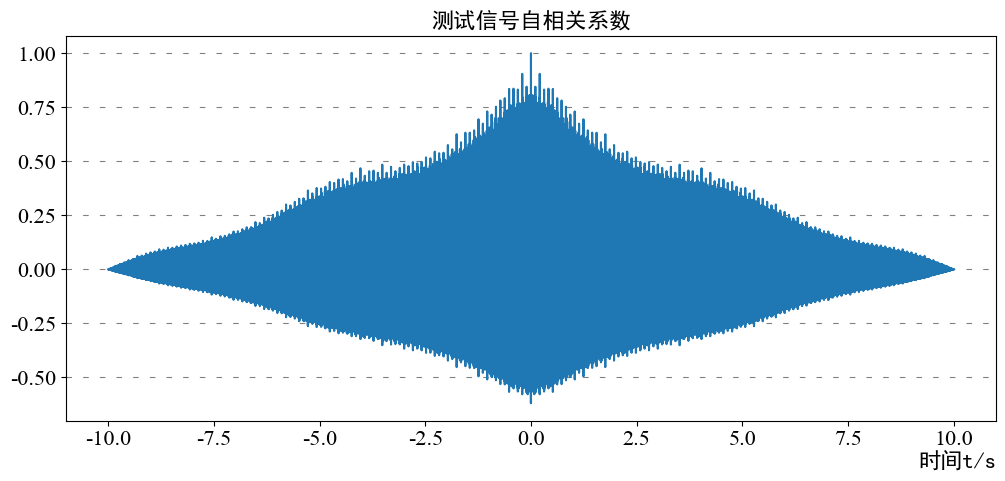

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import Time_Analysis

try:
    Sig=Signal(data=Data,label='测试信号',fs=12000)
    # Time_Analysis.Psd()
    Sig=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"概率密度函数",xlabel="幅值a/v").Pdf(samples=200)
    for i, r in enumerate(Sig):
        print(f"res{i+1}: ", type(r))
    # Time_Analysis.Trend()
    Sig=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"特征趋势图",xlabel="时间t/s").Trend(Feature="有效值",step=0.1,SegLength=0.2)
    for i,r in enumerate(Sig):
        print(f"res{i+1}: ",type(r))
    # Time_Analysis.Autocorr()
    Sig=Time_Analysis(Sig=Sig,plot=True,plot_save=False,title=Sig.label+"自相关系数",xlabel="时间t/s").Autocorr(std=True,both=True)
    for i,r in enumerate(Sig):
        print(f"res{i+1}: ",type(r))
except Exception as e:
    print(e)

### 3.3 BasicSP.Frequency_Analysis()

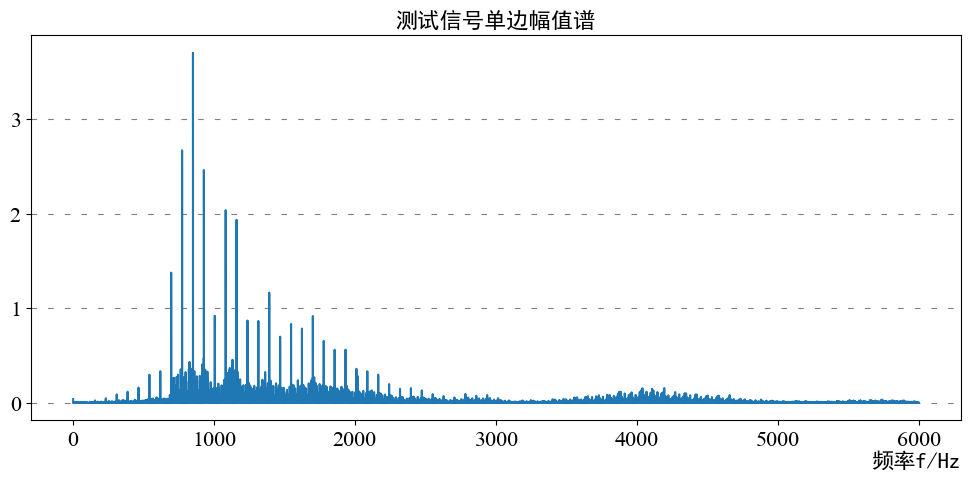

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import Frequency_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # Frequency_Analysis.Cft()
    Sig = Frequency_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "单边幅值谱",
        xlabel="频率f/Hz",
    ).Cft(WinType="汉宁窗")
    for i, r in enumerate(Sig):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)

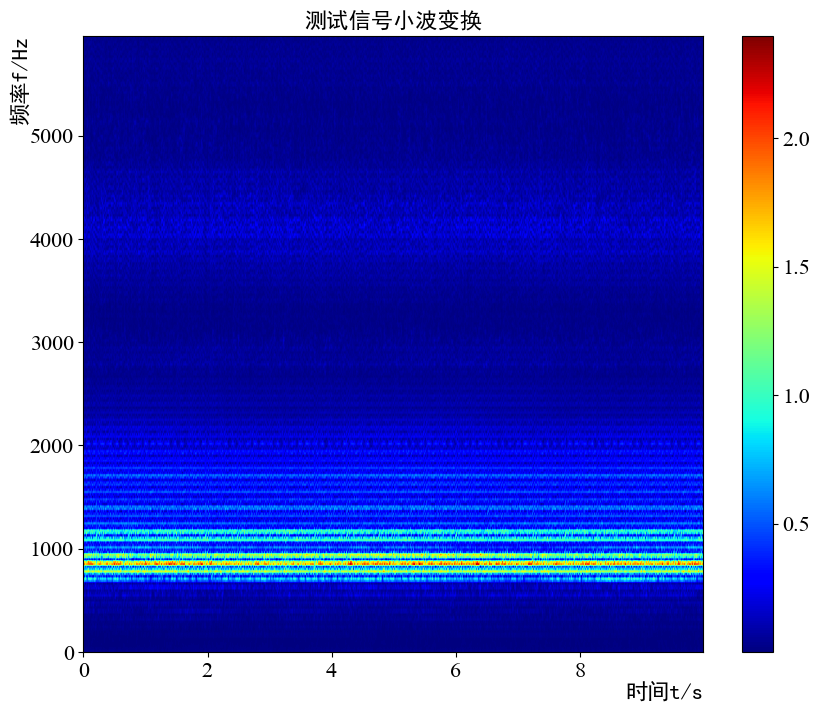

res1:  <class 'numpy.ndarray'>
res2:  <class 'numpy.ndarray'>
res3:  <class 'numpy.ndarray'>


In [ ]:
from PySP.BasicSP import TimeFre_Analysis

try:
    Sig = Signal(data=Data, label="测试信号", fs=12000)
    # TimeFre_Analysis.Wavelet()
    Sig = TimeFre_Analysis(
        Sig=Sig,
        plot=True,
        plot_save=False,
        title=Sig.label + "小波变换",
        xlabel="时间t/s",
        ylabel="频率f/Hz",
    ).st_Cft(nperseg=513, nhop=128,WinType="汉宁窗")
    for i, r in enumerate(Sig):
        print(f"res{i+1}: ", type(r))
except Exception as e:
    print(e)